In [1]:
!pip install torchmetrics
!pip install torchvision


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from  torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall
from PIL import Image
from sklearn.model_selection import train_test_split

import torchvision.transforms as transforms

import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [4]:
images = []
ages = []
genders = []

for i in os.listdir('./data'):
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append('./data/'+i)
    
d = {'age': ages, 'gender': genders, 'image': images}
data = pd.DataFrame(data= d)



In [5]:
data.head()

,age,gender,image
0,100,1,./data/100_1_0_20170110183726390.jpg.chip.jpg
1,100,1,./data/100_1_2_20170105174847679.jpg.chip.jpg
2,101,1,./data/101_1_2_20170105174739309.jpg.chip.jpg
3,10,0,./data/10_0_0_20161220222308131.jpg.chip.jpg
4,10,0,./data/10_0_0_20170103200329407.jpg.chip.jpg


In [6]:
data = data[data['gender'] != 3]
data = data[data['age'] <= 100]
data['age'] = pd.cut(data['age'], [-1, 18, 30, 80, data['age'].max()], labels=[0, 1, 2,3])
print(data['age'].unique())
print(data['gender'].unique())

[3, 0, 1, 2]
Categories (4, int64): [0 < 1 < 2 < 3]
[1 0]


In [7]:
print(data.shape)
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)

(9776, 3)
(9776, 3)


In [8]:
data['gender'].value_counts()

gender
1    5404
0    4372
Name: count, dtype: int64

In [9]:
train_df, test_df = train_test_split(data, test_size = 0.2, random_state= 42, shuffle= True)


In [10]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 2]
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor([self.dataframe.iloc[idx, 0], self.dataframe.iloc[idx, 1]], dtype= torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
   
])

In [12]:
train_dataset = ImageDataset(dataframe=train_df, transform = transform)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

img, lbl = next(iter(train_dataloader))
print(lbl)
print(img.shape)

tensor([[0., 0.],
        [2., 0.],
        [1., 1.],
        [1., 0.],
        [2., 0.],
        [2., 0.],
        [3., 1.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [1., 1.],
        [2., 0.],
        [1., 0.],
        [1., 1.],
        [0., 1.],
        [1., 1.],
        [2., 1.],
        [1., 1.],
        [1., 1.],
        [2., 1.],
        [2., 1.],
        [0., 0.],
        [2., 1.],
        [0., 1.],
        [2., 0.],
        [1., 1.],
        [0., 1.],
        [3., 1.],
        [2., 1.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [2., 1.],
        [2., 0.],
        [3., 0.],
        [0., 1.],
        [2., 1.],
        [1., 0.],
        [2., 1.],
        [0., 1.],
        [2., 0.],
        [0., 1.],
        [2., 0.],
        [0., 0.],
        [2., 0.],
        [2., 0.],
        [2., 1.],
        [2., 1.],
        [2., 1.],
        [0., 0.],
        [2., 1.],
        [0., 1.],
        [2., 1.],
        [2

In [14]:
img = img[0].permute(1, 2, 0)
print(img.shape)

torch.Size([224, 224, 3])


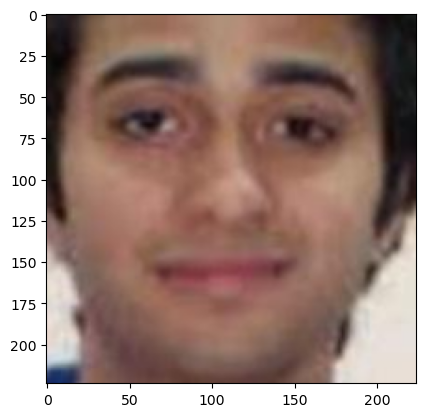

In [15]:
plt.imshow(img)
plt.show()

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiOutputCNN(nn.Module):
    def __init__(self):
        super(MultiOutputCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.dropout = nn.Dropout(0.5)
        
        self.flatten = nn.Flatten()
      
        self.fc1 = nn.Linear(256*7*7, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        
        self.fc2_age = nn.Linear(512, 1)
        self.fc2_gender = nn.Linear(512, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout(x)
        
        age = self.fc2_age(x)
        gender = torch.sigmoid(self.fc2_gender(x)).squeeze(1)
        
        return age, gender


In [17]:
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()

model = MultiOutputCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [18]:
num_epochs = 50
patience = 5  # Number of epochs to wait for improvement
min_delta = 0.001  # Minimum change to qualify as improvement

best_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    running_loss_age = 0.0
    running_loss_gender = 0.0
    
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        age_labels = labels[:, 0].float().unsqueeze(1)
        gender_labels = labels[:, 1].float()
        
        optimizer.zero_grad()
        
        outputs_age, outputs_gender = model(images)
        
        loss_age = criterion_age(outputs_age, age_labels)
        loss_gender = criterion_gender(outputs_gender, gender_labels)
        
        loss = loss_age + loss_gender
        loss.backward()
        optimizer.step()
        
        running_loss_age += loss_age.item()
        running_loss_gender += loss_gender.item()
    
    epoch_loss_age = running_loss_age / len(train_dataloader)
    epoch_loss_gender = running_loss_gender / len(train_dataloader)
    total_loss = epoch_loss_age + epoch_loss_gender

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss Age: {epoch_loss_age}, Loss Gender: {epoch_loss_gender}')
    
    # Check for early stopping
    if best_loss - total_loss > min_delta:
        best_loss = total_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break


Epoch [1/50], Loss Age: 1.4067459498963706, Loss Gender: 0.6705211367064375
Epoch [2/50], Loss Age: 0.7705203309291746, Loss Gender: 0.648305774219637
Epoch [3/50], Loss Age: 0.6119311107852594, Loss Gender: 0.6274729884736906
Epoch [4/50], Loss Age: 0.534552234701994, Loss Gender: 0.6132061433016769
Epoch [5/50], Loss Age: 0.5043150133233729, Loss Gender: 0.6030367796983176
Epoch [6/50], Loss Age: 0.430920608644563, Loss Gender: 0.5959155506234828
Epoch [7/50], Loss Age: 0.39597451226498054, Loss Gender: 0.5934620431768216
Epoch [8/50], Loss Age: 0.35396108382601077, Loss Gender: 0.5870379757105819
Epoch [9/50], Loss Age: 0.33469586728549583, Loss Gender: 0.5853388508160909
Epoch [10/50], Loss Age: 0.30305366000024286, Loss Gender: 0.5799398102411409
Epoch [11/50], Loss Age: 0.2850975634121313, Loss Gender: 0.5752414944695263
Epoch [12/50], Loss Age: 0.26481850554303427, Loss Gender: 0.5725257212553567
Epoch [13/50], Loss Age: 0.27108826373166184, Loss Gender: 0.5738246295510269
Epoch

In [19]:
torch.save(model.state_dict(), 'model.pth')

In [20]:
test_dataset = ImageDataset(dataframe=test_df, transform = transform)

test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [21]:
model.eval()
test_loss_age = 0.0
test_loss_gender = 0.0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        age_labels = labels[:, 0].float().unsqueeze(1)
        gender_labels = labels[:, 1].float()

        outputs_age, outputs_gender = model(images)

        loss_age = criterion_age(outputs_age, age_labels)
        loss_gender = criterion_gender(outputs_gender, gender_labels)

        test_loss_age += loss_age.item()
        test_loss_gender += loss_gender.item()

    print(f'Test Loss Age: {test_loss_age / len(test_dataloader)}, Test Loss Gender: {test_loss_gender / len(test_dataloader)}')


Test Loss Age: 0.18280648464156735, Test Loss Gender: 0.5563884896616782


In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, dataloader, criterion_age, criterion_gender):
    model.eval()  # Set model to evaluation mode
    
    all_age_preds = []
    all_age_labels = []
    all_gender_preds = []
    all_gender_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            age_labels = labels[:, 0].float()
            gender_labels = labels[:, 1].long()

            outputs_age, outputs_gender = model(images)

            # Store predictions and labels
            all_age_preds.extend(outputs_age.cpu().numpy().flatten())  # Continuous predictions
            all_age_labels.extend(age_labels.cpu().numpy())
            gender_preds = (outputs_gender > 0.5).float()
            all_gender_preds.extend(gender_preds.cpu().numpy())
            all_gender_labels.extend(gender_labels.cpu().numpy())
    
    # Calculate regression metrics for age
    mae_age = mean_absolute_error(all_age_labels, all_age_preds)
    mse_age = mean_squared_error(all_age_labels, all_age_preds)
    rmse_age = np.sqrt(mse_age)
    r2_age = r2_score(all_age_labels, all_age_preds)
    
    # Calculate classification metrics for gender
    accuracy_gender = accuracy_score(all_gender_labels, all_gender_preds)
    precision_gender = precision_score(all_gender_labels, all_gender_preds)
    recall_gender = recall_score(all_gender_labels, all_gender_preds)
    f1_gender = f1_score(all_gender_labels, all_gender_preds)
    
    return {
        'mae_age': mae_age,
        'rmse_age': rmse_age,
        'r2_age': r2_age,
        'accuracy_gender': accuracy_gender,
        'precision_gender': precision_gender,
        'recall_gender': recall_gender,
        'f1_gender': f1_gender
    }

# Usage example
metrics = evaluate_model(model, test_dataloader, criterion_age, criterion_gender)
print(metrics)


{'mae_age': 0.27755138, 'rmse_age': 0.42835996, 'r2_age': 0.8050554577143925, 'accuracy_gender': 0.8445807770961146, 'precision_gender': 0.8886618998978549, 'recall_gender': 0.8169014084507042, 'f1_gender': 0.8512720156555773}
